# EXPORT SHARES: UKRAINIAN AGRICULTURAL EXPORTS

Name: Josemaria Macedo Carrillo\
Created: 08/07/23\
Last modified: 09/07/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
# from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np
from utils.map import top_subsidiaries, top_parent, filter_country
import re
import copy
import os
import json
from config import IG_FILES_PATH, COUNTRY_FILES

Import company and country from "names.json" file

In [2]:
f = open('../names.json')
data = json.load(f)

KNOW_COMPANIES = data["KNOW_COMPANIES"]
ASIAN_COUNTRIES = data["ASIAN_COUNTRIES"]
ASIA_NAME_DICT = data["ASIA_NAME_DICT"]
SPAIN_NAME_DICT = data["SPAIN_NAME_DICT"]
BELGIUM_NAME_DICT = data["BELGIUM_NAME_DICT"]

## HELPER FUNCTIONS

In [3]:
def correct_name(series, name_dict):
    """
    Update column values from a dataframe with correct ones.

    Inputs:
        series (Series): column we want to update
        name_dict (dict): dictionary with incorrect names as keys and correct
            names as values.
    
    Returns: series with correct names.
    """
    return series.apply(lambda x: name_dict[x])

def filter_country(deals, country):
    """
    Filter land deals for a specific country

    Inputs:
        deals (DataFrame): dataframe with land deals data
        country (str): country name

    Returns (DataFrame): dataframe with country land locations
    """
    deals_c = deals.copy()
    deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
    deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains(country.lower(),
                                                                     na=False)]
    
    return deals_c

def extend_list(list, character):
    """
    Create new list with split text based on "character" parameter

    Inputs:
        list (lst): list of strings
        character (str): character to use to separate string values in list

    Returns (lst): new list with split text based on "character" parameter
    """
    new_lst = []
    for value in list:
        new_lst += value.split(character)

    return new_lst

def clean_list(list, pattern):
    """
    Create new list with clean text based on "pattern" parameter

    Inputs:
        list (lst): list of strings
        pattern (str): pattern we want to find and replace in each string value
            on the list

    Returns (lst): None. Makes changes in place in input "list".
    """
    for i, value in enumerate(list):
        match = re.search(pattern, value)
        if match:
            list[i] = match.group(0)

def parent_subsidiary_dict(parent_lst, deals_data, n_subsidiaries):
    """
    Create dictionary with parent companies as keys and subsidaries as values.

    Inputs:
        parent_lst (lst): list of parent companies
        deals_data (DataFrame): deals dataframe where we're going to look for
            subsidiaries
        n_subsidiaries (int): number of subsidiaries we want to get for parent
            company.

    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    subsidiaries_dict = {}

    for parent in parent_lst:
        subsidiaries_dict[parent] = top_subsidiaries(deals_data, parent,
                                                     n_subsidiaries)

    return subsidiaries_dict

def translate_subsidiaries(dict, source_lan, target_lan):
    """
    Create dictionary with translated subsidiaries' names as values.

    Inputs:
        dict (dict): dictionary with subsidarie names in English
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    d_target = {}

    for parent, sub_lst in dict.items():
        target_lst = []
        for subsidiary in sub_lst:
            target_lst.append(GoogleTranslator(source_lan, target_lan).\
                              translate(subsidiary))
        d_target[parent] = target_lst

    return d_target

def manually_add_subsidiaries(original_dict, manual_dict):
    """
    Add subsidaries manually as values to company dictionary.

    Inputs:
        manual_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    for parent, subsidiary_lst in manual_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()
        if parent in original_dict:
            original_dict[parent] += manual_dict[parent]
        else:
            original_dict[parent] = manual_dict[parent]

    return original_dict

def dict_to_lower(dict):
    """
    Convert dictionary values of 'dict' to lowercase

    Inputs:
        dict (dict): dictionary with parent companies as keys and subsidaries
            as values.

    Returns (dict): None. The function does the change in place of the input
        'dict'.
    """
    for parent, subsidiary_lst in dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

def add_companies_manually(old_dict, new_dict):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): dictionary with non-repeated values from 'new_dict' to
        'old_dict' based on keys.
    """
    old_dict_copy = copy.deepcopy(old_dict)
    
    for parent, subsidiary_lst in new_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

        if parent in old_dict_copy:
            # old_dict_copy[parent] += new_dict[parent]
            old_dict_copy[parent].extend(subsidiary_lst)
        else:
            # old_dict_copy[parent] = new_dict[parent]
            old_dict_copy[parent] = subsidiary_lst
    
    return old_dict_copy

def estimate_table_percentages(table):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): None. The function does the change in place of the input
        'old_dict'.
    """
    table = table.fillna(0)
    date = table["date"]
    percentage_df = table.drop(columns=["date"]).divide(table.drop(columns=\
                                            ["date"]).sum(axis=1), axis=0) * 100
    percentage_df = percentage_df.round(2)
    percentage_df["date"] = date
    
    return percentage_df

def plot_multiple_countries(country_dict, data, y_axis_limit, source):
    """
    Plot stacked bar charts for more than one country

    Inputs:
        country_dict (dict): dictionary with country names in BSGI as keys
            (in English) and country names in IG as values (Ukrainian)
        data (DataFrame): dataset with information to plot
        y_axis_limit (int): y axis limit in scale
        source (str): text to say which is the data source for the plot.

    Returns (dict): None. The function plots the stacked bar charts.
    """
    for country_en, country_uk in country_dict.items():
        ig_country = data[data["country"] == country_uk]
        pivot_country = create_wide_table(ig_country,
                                          ["year", "month", "company_std"],
                                          ["weight_ton"],
                                          ["year", "month", "company_std"], True,
                                          {"weight_ton": "sum"})
        plot_stack_bar(pivot_country, "Total exports by company",
                       "Weight of exports (metric tons)",
                       f"Total exports to {country_en.capitalize()} by company",
                       "date", y_axis_limit, source)

def plot_all_period(data, source, min_wedge_percentage=2,
                    min_legend_percentage=0):
    """
    Plot a pie chart to estimate the export shares for the whole period of time
        (August 2022 until March 2023), not by month.

    Inputs:
        data (DataFrame): dataset with information to plot
        source (str): text to say which is the data source for the plot
        min_wedge_percentage (float, optional): minimum percentage threshold for
            annotating wedges (default is 2)
        min_legend_percentage (float, optional): minimum percentage threshold
            for adding wedges legend (default is 0).

    Returns (DataFrame): table used to plot pie chart.
    """
    whole_period_g = cargo_grouping(data, ["company_std"], ["weight_ton"],
                                    ["weight_ton"], False, {"weight_ton": "sum"})
    whole_period_g = whole_period_g.reset_index(drop=True)
    plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"],
             "Company category",
             "Share of exports (metric tons) exported by company", source,
             min_wedge_percentage, min_legend_percentage)
    
    return whole_period_g
    
def create_subsidiary_dict(n_parent_companies, n_subsidiaries, ig_data):
    """
    Create dictionary with parent companies as keys and subsidiaries as values
        using Land Matrix data.

    n_parent_companies (int): top 'n' parent companies we want to 
    """
    # Import Land Matrix data and create list with top parent companies
    deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
    deals_c = filter_country(deals, "ukraine")
    parent_lst = top_parent(deals_c, n_parent_companies)
    parent_lst = extend_list(parent_lst, "|")

    # Regex cleans parent company names. Names include deal_id as 'Kernel #366#'
    # Function removes specified regex pattern.
    pattern = r'^.*?(?=#\d+#)'
    clean_list(parent_lst, pattern)

    # Create dictionary with parent companies as keys and subsidiaries as values
    subsidiaries_dict = parent_subsidiary_dict(parent_lst, deals_c, n_subsidiaries)

    # Translate subsidiary names to Ukrainian to try to match them to IG shipper
    # names which are in Ukrainian
    subsidiaries_uk = translate_subsidiaries(subsidiaries_dict, "en", "uk")

    # Turn company values to lowercase both in subsidiary dictionary and IG
    # shipper column
    dict_to_lower(subsidiaries_uk)
    ig_data["shipper_low"] = ig_data["shipper"].str.lower()

    # Manually add some companies we identified separately
    subsidiaries_c = add_companies_manually(subsidiaries_uk, KNOW_COMPANIES)

    return subsidiaries_c

def generate_path(countries):
    """
    Generate path where file is located.

    Inputs:
       countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.
    
    Return (str): file path where file is located.
    """
    try:
        country_file = COUNTRY_FILES[countries]
    except KeyError:
        print("Wrong countries' name. Use 'asia', 'spain' or 'belgium'.")
    except:
        print("Unknown error")
    
    path = os.path.join(IG_FILES_PATH, COUNTRY_FILES[countries])

    return path

def get_ig(countries):
    """
    Get Import Genius (IG) data for specific countries.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.

    Returns (DataFrame): table with filtered Import Genius data.
    """

    path = generate_path(countries)
    ig = get_data("ig", path)

    if countries == "asia":
        country_name_dict = ASIA_NAME_DICT
    elif countries == "spain":
        country_name_dict = SPAIN_NAME_DICT
    elif countries == "belgium":
        country_name_dict = BELGIUM_NAME_DICT

    # We standardize the "country" values in the IG dataset
    ig["country"] = correct_name(ig["country"], country_name_dict)

    # We only keep crops that are included both in IG and BSGI
    ig = ig[ig["bsgi_commodity"]!= "Not in BSGI"]

    subsidiaries_dict = create_subsidiary_dict(25, 20, ig)
    ig_c = ig.copy()
    ig_c["company_std"] = standard_company_name(ig["shipper_low"], subsidiaries_dict)

    return ig_c

def get_bsgi(countries):
    """
    Get Black Sea Grain Initiative (BSGI) data for specific countries.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.

    Returns (DataFrame): table with filtered BSGI data.
    """
    
    # assert_countries(countries)
    bsgi = get_data("bsgi")

    # We filter only corresponding months and countries in BSGI dataset
    
    if countries == "asia":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            ((bsgi["country_en"] == "india") |
                             (bsgi["country_en"] == "sri lanka") |
                             (bsgi["country_en"] == "viet nam"))]
    elif countries == "spain":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            (bsgi["country_en"] == "spain")]
    elif countries == "belgium":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            (bsgi["country_en"] == "belgium")]
    else:
        print("Wrong countries' name. Use 'asia', 'spain' or 'belgium'.")

    return bsgi_country


## TOTAL EXPORTS BY COMPANY

### PIE CHART FOR WHOLE PERIOD (August 2022 -  March 2023)

We get the data from Import Genius (IG) and Black Sea Grain Initiative (BSGI) for some countries ("asia" or "spain").

In [4]:
ig = get_ig("belgium")
bsgi = get_bsgi("belgium")

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49617/2316318826.py:257: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural

Plot export shares for the whole period (August 2022 until March 2023)

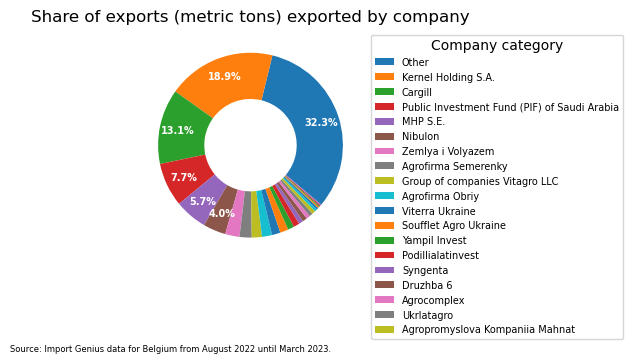

,company_std,weight_ton
0,Other,149740.43372
1,Kernel Holding S.A.,87833.35436
2,Cargill,60909.32300
3,Public Investment Fund (PIF) of Saudi Arabia,35593.26400
4,MHP S.E.,26338.65000
5,Nibulon,18411.37500
6,Zemlya i Volyazem,11583.54600
7,Agrofirma Semerenky,9847.40000
8,Group of companies Vitagro LLC,8263.31000
9,Agrofirma Obriy,8147.78400


In [5]:
# TODO: Use keyword arguments if it's not obvious what something is - 2, .5 for example
data_source = "Import Genius data for Belgium from August 2022 until March 2023"

export_shares_all = plot_all_period(ig, data_source, min_wedge_percentage=3, min_legend_percentage=.5)
export_shares_all

### MONTHLY STACKED BAR CHARTS

We convert the IG dataframe to a wide format so we can plot the monthly stacked bar charts.

In [6]:
# TODO: same note on keyword arguments
# Also, not totally clear what we are doing by passing different columns as arguments
grouping_cols = ["year", "month", "company_std"]
other_cols = ["weight_ton"]
sort_by = ["year", "month", "company_std"]
sort_ascending = True
aggregate_by = {"weight_ton": "sum"}

pivot = create_wide_table(df=ig, group=grouping_cols, agg_cols=other_cols,
                          sort=sort_by, asc_bool=True, agg_dict=aggregate_by,
                          new_name=None)
pivot

company_std,date,Agrocomplex,Agrofirma Obriy,Agrofirma Semerenky,Agropromyslova Kompaniia Mahnat,Cargill,Druzhba 6,Eridon PE,Group of companies Vitagro LLC,Karla Marksa 2,...,Public Investment Fund (PIF) of Saudi Arabia,Soufflet Agro Ukraine,Syngenta,Tavamis Hrup,Ukrlatagro,Vesele-Agro LLC,Viterra Ukraine,Vizmir Market,Yampil Invest,Zemlya i Volyazem
6,9/2022,NaN,8147.8,NaN,NaN,15825.1,NaN,NaN,NaN,55.4,...,6187.7,421.7,760.5,2041.5,2919.5,1583.4,6874.4,NaN,5060.4,NaN
1,10/2022,NaN,NaN,NaN,NaN,999.9,NaN,NaN,NaN,NaN,...,NaN,5887.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/2022,NaN,NaN,NaN,NaN,32038.8,NaN,NaN,8263.3,NaN,...,17388.8,183.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1/2023,3066.9,NaN,9847.4,2826.6,12045.5,3624.9,1016.4,NaN,NaN,...,12016.7,246.6,2918.9,NaN,NaN,NaN,NaN,881.2,NaN,NaN
4,2/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11583.5


Now we do the same but we estimate the percentages of the wide table

In [7]:
percentages = pivot.copy()
percentages_df = estimate_table_percentages(percentages)
percentages_df

company_std,Agrocomplex,Agrofirma Obriy,Agrofirma Semerenky,Agropromyslova Kompaniia Mahnat,Cargill,Druzhba 6,Eridon PE,Group of companies Vitagro LLC,Karla Marksa 2,Kernel Holding S.A.,...,Soufflet Agro Ukraine,Syngenta,Tavamis Hrup,Ukrlatagro,Vesele-Agro LLC,Viterra Ukraine,Vizmir Market,Yampil Invest,Zemlya i Volyazem,date
6,0.00,6.09,0.00,0.00,11.82,0.00,0.00,0.00,0.04,0.01,...,0.32,0.57,1.53,2.18,1.18,5.14,0.0,3.78,0.00,9/2022
1,0.00,0.00,0.00,0.00,2.75,0.00,0.00,0.00,0.00,0.00,...,16.21,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,10/2022
2,0.00,0.00,0.00,0.00,33.40,0.00,0.00,8.62,0.00,0.15,...,0.19,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,11/2022
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,12/2022
0,2.79,0.00,8.94,2.57,10.94,3.29,0.92,0.00,0.00,35.73,...,0.22,2.65,0.00,0.00,0.00,0.00,0.8,0.00,0.00,1/2023
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2/2023
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77.18,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,18.51,3/2023


Now we plot the stacked bar with our wide format table we created earlier.

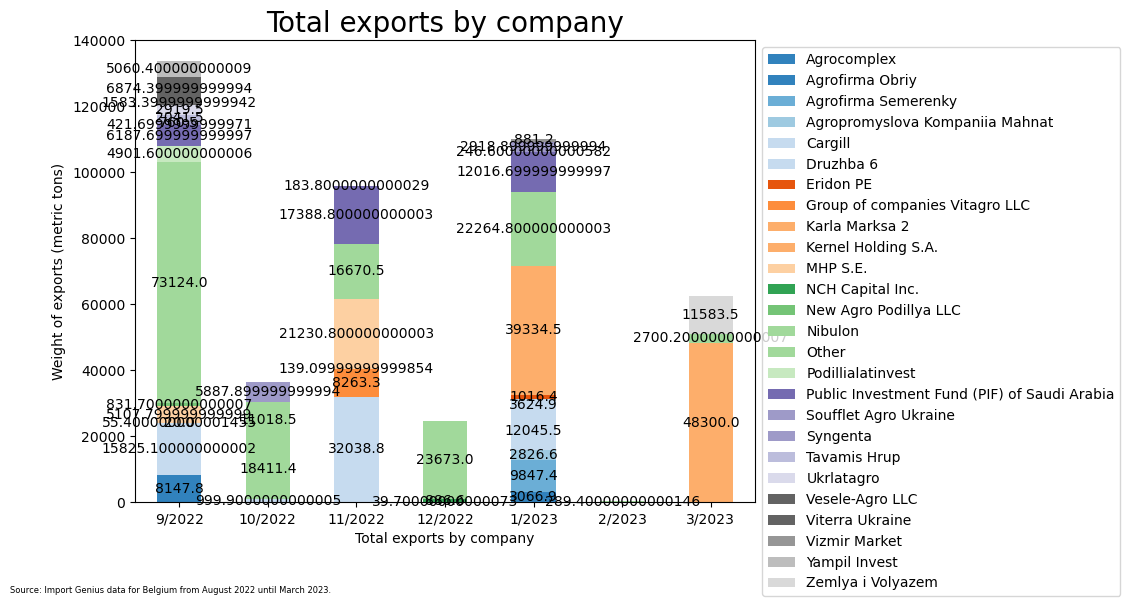

In [8]:
x_title = "Total exports by company"
y_title = "Weight of exports (metric tons)"
plot_title = "Total exports by company"
x_axis_ticks = "date"
y_axis_limit = 140000

plot_stack_bar(df=pivot, x_title=x_title, y_title=y_title, plot_title=plot_title,
               x_ticks=x_axis_ticks, ylim=y_axis_limit, data_source=data_source)

Now we do the same but with percentages

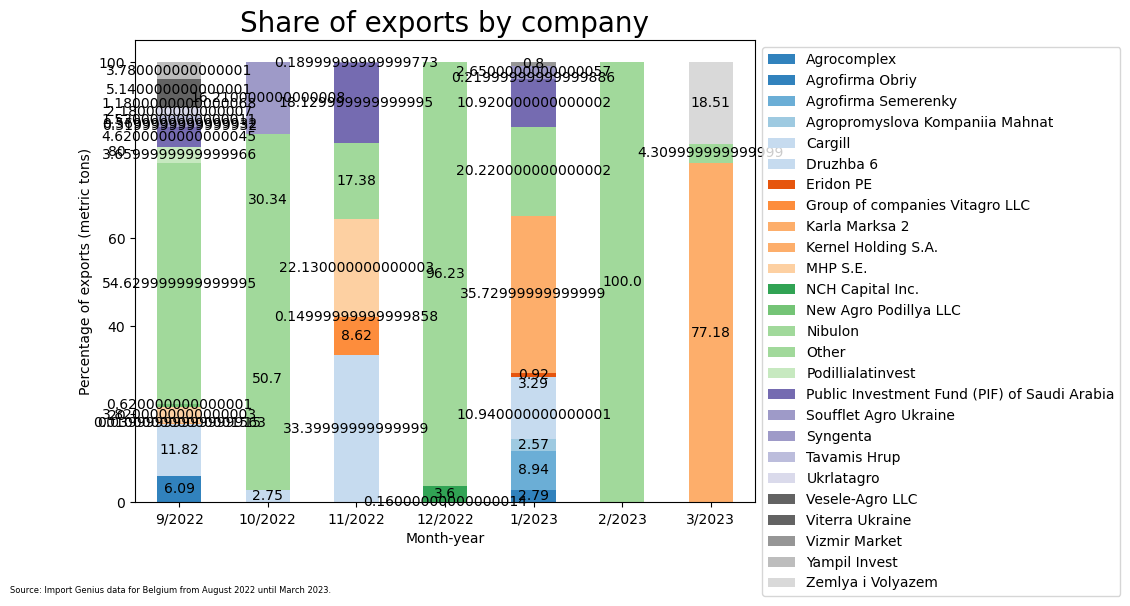

In [9]:
x_title = "Month-year"
y_title = "Percentage of exports (metric tons)"
plot_title = "Share of exports by company"
y_axis_limit = 105

plot_stack_bar(df=percentages_df, x_title=x_title, y_title=y_title,
               plot_title=plot_title, x_ticks=x_axis_ticks, ylim=y_axis_limit,
               data_source=data_source)

## TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

Now we get the whole table with all companies exporting to Ukraine to export it and share it with Oakland Institute (OI).

First we create a new column with all the company names, including the ones from unknown companies whose names are still in Ukrainian.

In [10]:
ig["company_all"] = ig["company_std"]
for idx, row in ig.iterrows():
    if row["company_std"] == "Other":
        ig["company_all"][idx] = ig["shipper"][idx]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49617/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig["company_all"][idx] = ig["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49617/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig["company_all"][idx] = ig["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49617/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

We only keep the columns that we care about which are the subsidiary name, parent company name and weight of exported commodities by the subsidiary.

In [11]:
ig_new = ig[["shipper", "company_std", "weight_ton"]]
ig_new.sort_values("weight_ton", ascending=False).head(10)

,shipper,company_std,weight_ton
1334,ТОВ ЕНСЕЛКО АГРО 31134 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИ...,Kernel Holding S.A.,48300.000
3368,СТОВ ДРУЖБА НОВА 17600 ЧЕРНІГІВСЬКА ОБЛ ПРИЛУЦ...,Kernel Holding S.A.,21406.888
5915,ТОВ СП НІБУЛОН 54002 МИКОЛАЇВСЬКА ОБЛ М МИКОЛА...,Nibulon,18411.375
3367,СТОВ ДРУЖБА НОВА 17600 ЧЕРНІГІВСЬКА ОБЛ ПРИЛУЦ...,Kernel Holding S.A.,17907.786
1332,ТОВ ЗЕМЛЯ І ВОЛЯ 17400 ЧЕРНІГІВСЬКА ОБЛ М БОБР...,Zemlya i Volyazem,11583.546
3375,ТОВ АГРОФІРМА СЕМЕРЕНЬКИ 42644 СУМСЬКА ОБЛ ОХТ...,Agrofirma Semerenky,9847.400
2713,ТОВ СІЕФДЖІ ТРЕЙДИНГ 47602 ТЕРНОПІЛЬСЬКА ОБЛ Т...,Public Investment Fund (PIF) of Saudi Arabia,8144.030
8519,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОФІ...,Agrofirma Obriy,8134.025
8603,ТОВ АТ КАРГІЛЛ 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАС...,Cargill,7006.960
2581,ТОВ АТ КАРГІЛЛ 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАС...,Cargill,6034.450


We create a new column with the company names translated from Ukrainian to English.

In [ ]:
translate_column(ig_new, "shipper", "google", source="uk", target="en") # this step takes awhile

/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/clean_data.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column.lower() + "_gt"] = df[column].apply(lambda x: d[x])


We rename and reorder the columns

In [ ]:
ig_clean = ig_new.rename(columns={"shipper": "subsidiary", "company_std": "parent_company", "weight_ton": "weight_ton_subs", "shipper_gt": "subsidiary_en"})\
    [["subsidiary", "subsidiary_en", "parent_company", "weight_ton_subs"]].\
        sort_values(by = "weight_ton_subs", ascending=False)
ig_clean.head()
ig_clean.columns

Index(['subsidiary', 'subsidiary_en', 'parent_company', 'weight_ton_subs'], dtype='object')

We group repeated subsidiaries so we can aggregate their exports

In [ ]:
ig_clean_g = ig_clean.groupby(["subsidiary", "subsidiary_en", "parent_company"], as_index=False).\
    sum("weight_ton_subs").sort_values(by=["weight_ton_subs"], ascending=False)
ig_clean_g

,subsidiary,subsidiary_en,parent_company,weight_ton_subs
77,ТОВ АТ КАРГІЛЛ 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАС...,JSC CARGILL 03150 KYIV CITY 139 VELIKA VASYLKI...,Cargill,59114.80000
99,ТОВ ЕНСЕЛКО АГРО 31134 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИ...,TOV ENSELCO AGRO 31134 Khmelnytskyi Oblast Khm...,Kernel Holding S.A.,48300.00000
44,СТОВ ДРУЖБА НОВА 17600 ЧЕРНІГІВСЬКА ОБЛ ПРИЛУЦ...,STOV DRUZHBA NOVA 17600 CHERNIGIVSKA OBL PRYLU...,Kernel Holding S.A.,39314.67400
137,ТОВ СІЕФДЖІ ТРЕЙДИНГ 47602 ТЕРНОПІЛЬСЬКА ОБЛ Т...,SIEFJI TRADING LLC 47602 TERNOPILSK REGION TER...,Public Investment Fund (PIF) of Saudi Arabia,30117.64000
144,ТОВ СП НІБУЛОН 54002 МИКОЛАЇВСЬКА ОБЛ М МИКОЛА...,LLC SP NIBULON 54002 MYKOLAIVSKA OBL M MYKOLAI...,Nibulon,18411.37500
...,...,...,...,...
148,ТОВ ТРИПЛЕКС ПЛЮС 49038 М ДНІПРО ПР ДМИТРА ЯВО...,LLC TRIPLEX PLUS 49038 M DNIPRO PR DMYTRA YAVO...,Other,19.86700
122,ТОВ НЕМИРІВЛАТІНВЕСТ 22812 ВІННИЦЬКА ОБЛ ВІННИ...,NEMYRIVLATINVEST LLC 22812 Vinnytsia Oblast Vi...,Other,9.37100
147,ТОВ ТЕМП УКРАЇНА УКРАЇНА 90130 ЗАКАРПАТСЬКА ОБ...,TOV TEMP UKRAINE UKRAINE 90130 ZAKARPATSKA OBL...,Other,0.99000
173,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АТЛАНТ...,ATLANTA MARIN LIMITED LIABILITY COMPANY 65078 ...,Other,0.11400


We export the table as a .csv file.

In [ ]:
file_name = "total_exports_by_company_belgium_v2.csv"
path = os.path.join("../data", file_name)

ig_clean_g.to_csv(path, index=False)
ig_clean_g.head()

,subsidiary,subsidiary_en,parent_company,weight_ton_subs
77,ТОВ АТ КАРГІЛЛ 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАС...,JSC CARGILL 03150 KYIV CITY 139 VELIKA VASYLKI...,Cargill,59114.800
99,ТОВ ЕНСЕЛКО АГРО 31134 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИ...,TOV ENSELCO AGRO 31134 Khmelnytskyi Oblast Khm...,Kernel Holding S.A.,48300.000
44,СТОВ ДРУЖБА НОВА 17600 ЧЕРНІГІВСЬКА ОБЛ ПРИЛУЦ...,STOV DRUZHBA NOVA 17600 CHERNIGIVSKA OBL PRYLU...,Kernel Holding S.A.,39314.674
137,ТОВ СІЕФДЖІ ТРЕЙДИНГ 47602 ТЕРНОПІЛЬСЬКА ОБЛ Т...,SIEFJI TRADING LLC 47602 TERNOPILSK REGION TER...,Public Investment Fund (PIF) of Saudi Arabia,30117.640
144,ТОВ СП НІБУЛОН 54002 МИКОЛАЇВСЬКА ОБЛ М МИКОЛА...,LLC SP NIBULON 54002 MYKOLAIVSKA OBL M MYKOLAI...,Nibulon,18411.375


## EXPLORATORY ANALYSIS FOR MANUAL COMPANY MATCHING

We first get the top n companies exporting to Ukraine.

In [ ]:
tempo = cargo_grouping(ig, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
tempo.sort_values(by=["weight_ton"], ascending=False)[:50]

,company_all,weight_ton
9,Kernel Holding S.A.,87833.35436
4,Cargill,60909.32300
15,Public Investment Fund (PIF) of Saudi Arabia,35593.26400
10,MHP S.E.,26338.65000
13,Nibulon,18411.37500
24,Zemlya i Volyazem,11583.54600
2,Agrofirma Semerenky,9847.40000
7,Group of companies Vitagro LLC,8263.31000
1,Agrofirma Obriy,8147.78400
21,Viterra Ukraine,6874.45000


Then we get the full company name.

In [ ]:
tempo.loc[82]["company_all"]

'ТОВ АГРОФІРМА РУБАНСЬКИЙ УКРАЇНА 23400 ВІННИЦЬКА ОБЛ МОГИЛІВ ПОДІЛЬСЬКИЙ Р Н СМТ МУРОВАНІ'

We double check that the company is actually exporting crops to confirm we filtered the IG dataset correctly with companies that only export agricultural products that appear in BSGI.

In [ ]:
ig[ig["shipper"] == 'ТОВ ЗЕМЛЯ І ВОЛЯ 17400 ЧЕРНІГІВСЬКА ОБЛ М БОБРОВИЦЯ ВУЛ ЧЕРНІГІВСЬКА 34']["product"]

1332    кукурудза: - інша
Name: product, dtype: object

We check if there are any name matches with the Land Matrix company parents we found
in Land Matrix.

First we get the Land Matrix data.

In [ ]:
deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
deals_c = deals.copy()
deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains("ukraine", na=False)]
deals_c["Target country"]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_48346/99570549.py:1: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")


572     Ukraine
573     Ukraine
574     Ukraine
575     Ukraine
576     Ukraine
         ...   
6461    Ukraine
6462    Ukraine
6463    Ukraine
6464    Ukraine
6467    Ukraine
Name: Target country, Length: 358, dtype: object

Then we look for companies matches manually in Land Matrix data.

In [ ]:
deals_c[deals_c["Top parent companies"].str.lower().str.contains("vol")]["Top parent companies"]

2425                          Volynzernoproduct LLC#5023#
3659    Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#...
4707    Johann Yager Jacob#41994#|Venhri Agrar#41995#|...
5527                          Volodarsk Inagro LLC#43420#
6163    Chuikevych Volodymyr#44276#|Karbovnichyi Andri...
Name: Top parent companies, dtype: object

In [ ]:
sorted(deals_c["Top parent companies"].unique())

['AGR Invest Holding Ltd#40757#',
 'AGT Capital Management Ltd.#41248#',
 'Agro Ukraina AB#44407#',
 'Agro-Podillya i K LLC#43419#',
 'AgroGeneration#656#',
 'AgroGeneration#656#|Azent Ltd.#40783#',
 'AgroGeneration#656#|L`ost Dominic#41121#|Mandua Catrin#41123#|Claud Mandua#41124#',
 'Agromino A/S#4970#',
 'Agroton Public Limited#38647#',
 'Agrovista Limited#41491#',
 'Akella Impex LP#5042#',
 'Aladin tekstil ve hiyim iuriunleri tidzharet LLC#44904#',
 'Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#|Vorotyntsev Vitaliy#5064#',
 'Albus Gunter#41907#',
 'Alexander Wolters#41898#',
 'Alpha-Capital LLC#44409#',
 'Aslan Global Management#1779#',
 'BKW Group LLC#43027#',
 'Berend Popke van der Velde#40762#|Herrit Tonkens#40763#|Huzinha Kornelius Hendrick#40764#|Oxana Kryachko#40765#',
 'Berry Farma ApS#5060#',
 'Bitex Trade Ltd.#43046#',
 'Bontrup Holding#4963#',
 'Brunner&Partner LLC#5047#|Glendore Holding LLC#5048#',
 "Brykivs'ke LLC#43422#",
 'CNBM International energy PTE.LTD#44677#',
 

## DIFFERENCE IN EXPORTS BETWEEN IG AND BSGI

We do some analysis to see why we have differences in export weights between IG and BSGI.

In [ ]:
ig_g = cargo_grouping(ig, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,9/2022,133862.5,69763
1,10/2022,36317.7,82270
2,11/2022,95915.2,44900
3,12/2022,24599.3,214645
4,1/2023,110090.4,45000
5,3/2023,62583.8,62088


Text(-90, -60, 'Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.')

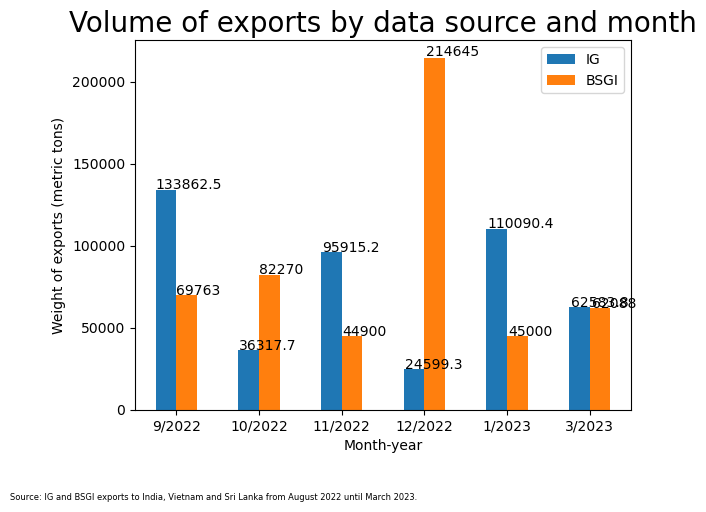

In [ ]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')